In [1]:
%cd ../..

/mnt/batch/tasks/shared/LS_root/mounts/clusters/jeffrey-uso9-03-dev-ci01/code/Users/jeffrey.tackes/ModernTS_2E


In [2]:
import os
import shutil
import json

import joblib
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

from pathlib import Path

from tqdm.autonotebook import tqdm
from IPython.display import display, HTML
# %load_ext autoreload
# %autoreload 2
np.random.seed(42)
tqdm.pandas()

from statsforecast import StatsForecast
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
from neuralforecast.auto import AutoPatchTST
from neuralforecast.losses.pytorch import MQLoss
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mse, mase
from functools import partial

from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch


import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

/tmp/ipykernel_402046/1721154343.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-08-16 17:28:23,705	WARNING __init__.py:21 -- Package pickle5 becomes unnecessary in Python 3.8 and above. Its presence may confuse libraries including Ray. Please uninstall the package.
/anaconda/envs/demand_planning/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
TRAIN_SUBSAMPLE = True  # Trains a subsample of IDs to improve run speed
RETUNE = True  # if false, will use pre-trained hyperparameters when generating the AUTO NeuralForecast

In [4]:
preprocessed = Path("data/london_smart_meters/preprocessed")
output = Path("data/london_smart_meters/output")
try:
    #Reading the missing value imputed and train test split data
    train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed_feature_engg.parquet")
    # Read in the Validation dataset as test_df so that we predict on it
    test_df = pd.read_parquet(preprocessed/"selected_blocks_val_missing_imputed_feature_engg.parquet")
    # test_df = pd.read_parquet(preprocessed/"selected_blocks_test_missing_imputed_feature_engg.parquet")
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 01-Feature Engineering.ipynb in Chapter06
    </div>
    """))

In [5]:
train_df.head(2)

timestamp      LCLid  energy_consumption frequency  series_length  \
0 2012-01-01 00:00:00  MAC000061               0.114     30min          37872   
1 2012-01-01 00:30:00  MAC000061               0.113     30min          37872   

  stdorToU    Acorn Acorn_grouped      file    holidays  ...  \
0      Std  ACORN-Q     Adversity  block_96  NO_HOLIDAY  ...   
1      Std  ACORN-Q     Adversity  block_96  NO_HOLIDAY  ...   

   timestamp_Minute_sin_1  timestamp_Minute_sin_2  timestamp_Minute_sin_3  \
0            0.000000e+00            0.000000e+00            0.000000e+00   
1            5.665539e-16           -1.133108e-15            2.143751e-15   

   timestamp_Minute_sin_4  timestamp_Minute_sin_5  timestamp_Minute_cos_1  \
0            0.000000e+00            0.000000e+00                     1.0   
1           -2.266215e-15            6.123234e-16                    -1.0   

   timestamp_Minute_cos_2 timestamp_Minute_cos_3 timestamp_Minute_cos_4  \
0                     1.0                    1.0                    1.0   
1                     1.0                   -1.0                    1.0   

   timestamp_Minute_cos_5  
0                     1.0  
1                    -1.0  

[2 rows x 94 columns]

In [6]:
print("Total # of IDs Pre-Sampling: ", len(train_df.LCLid.unique()))

Total # of IDs Pre-Sampling:  150


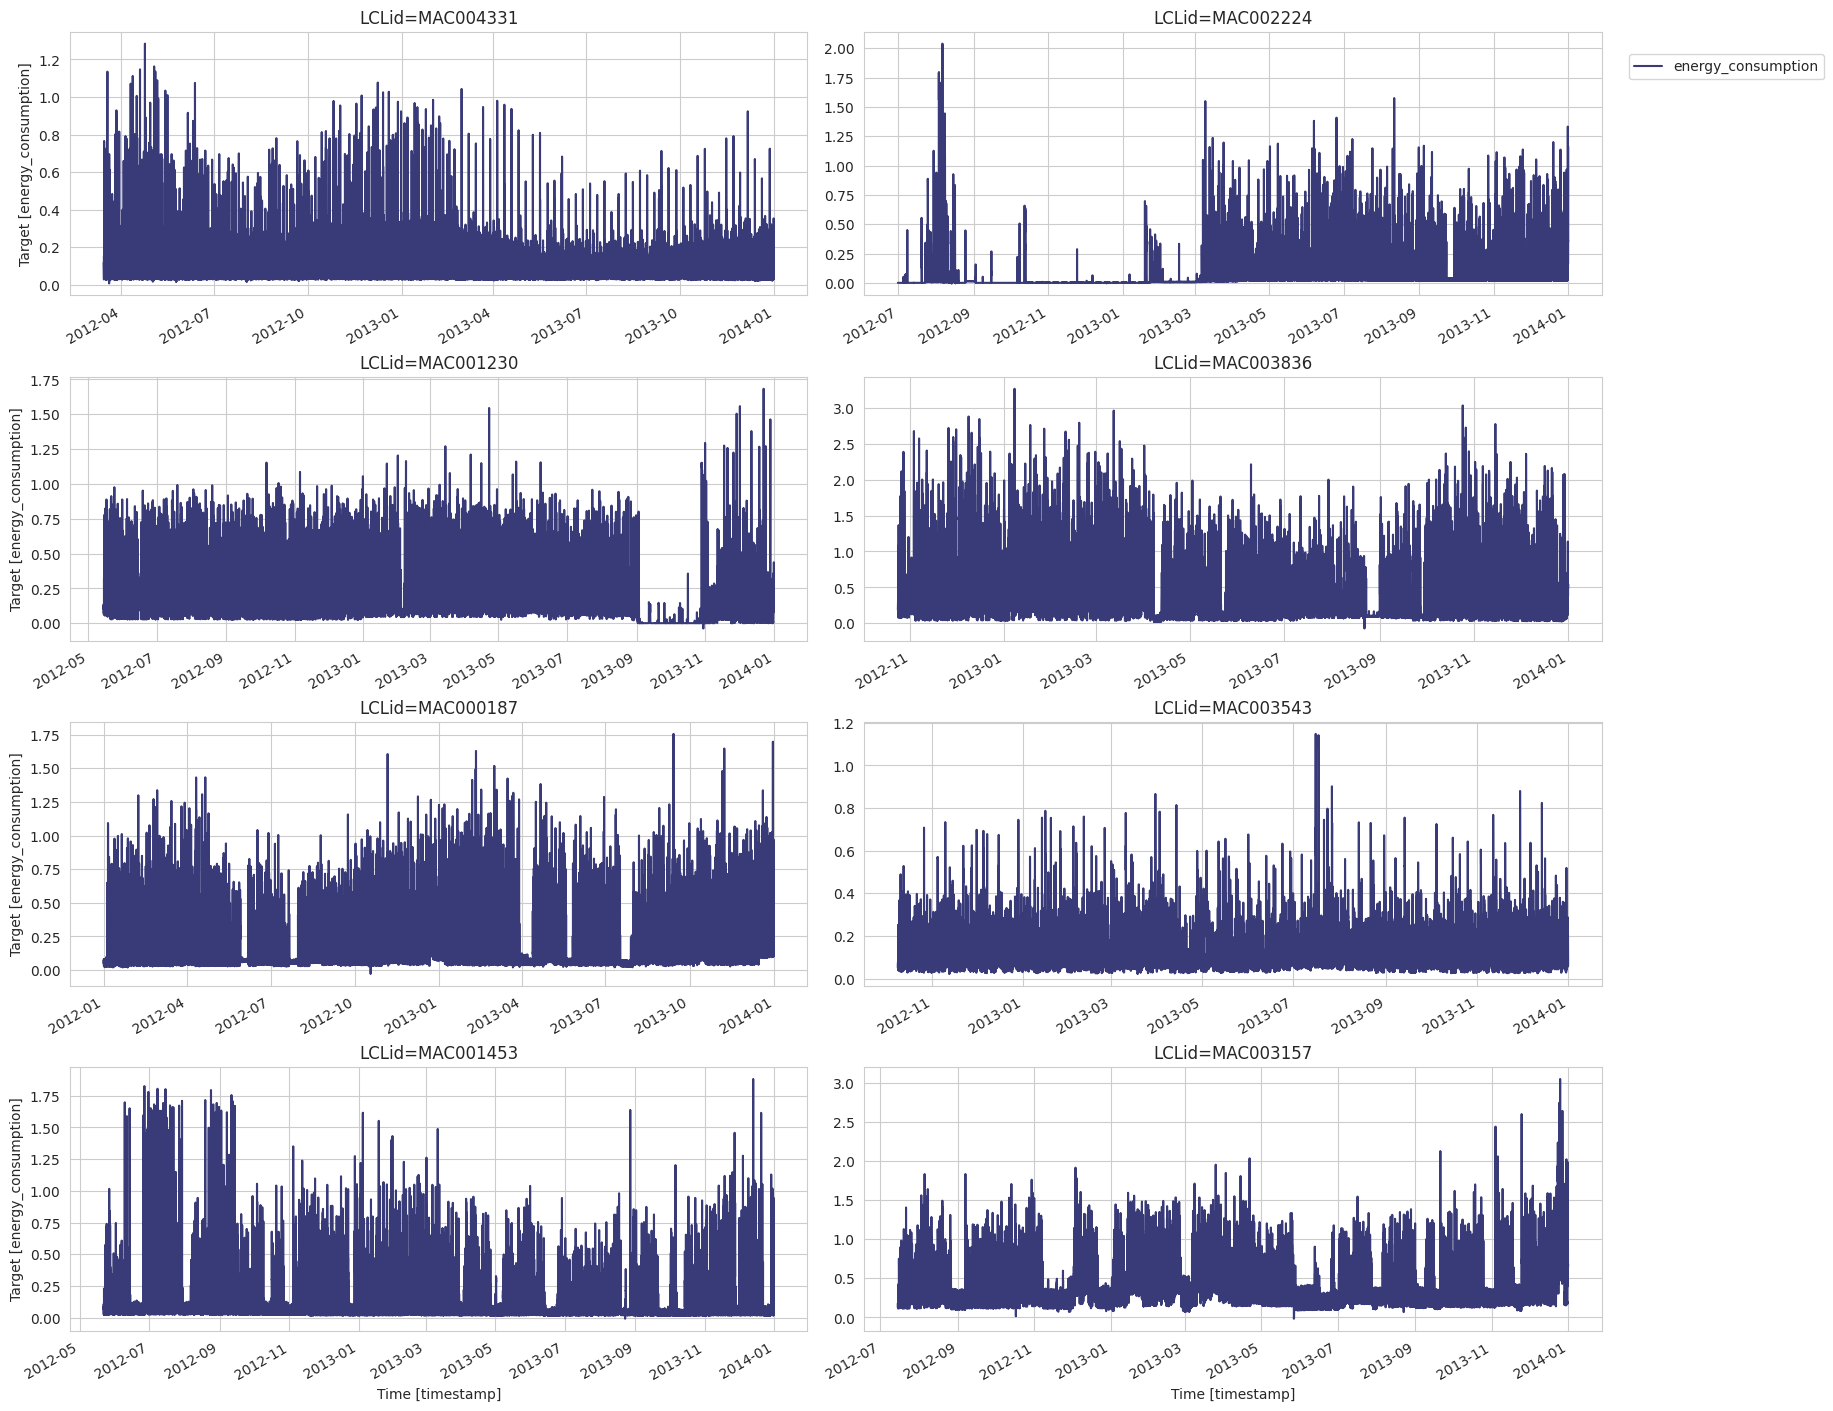

In [7]:
StatsForecast.plot(train_df, engine='matplotlib', id_col='LCLid',time_col= 'timestamp', target_col='energy_consumption')

In [8]:
# To run on smaller set of data for daster iteration.
if TRAIN_SUBSAMPLE:
    print("sub sampling")
    SAMPLE = 10
    sampled_LCLids = pd.Series(train_df.LCLid.unique().remove_unused_categories().categories).sample(SAMPLE, random_state=99).tolist()
    train_df = train_df.loc[train_df.LCLid.isin(sampled_LCLids)]
    test_df = test_df.loc[test_df.LCLid.isin(sampled_LCLids)]

sub sampling


In [9]:
print("Total # of IDs Post Sampling: ", len(train_df.LCLid.unique()))

Total # of IDs Post Sampling:  10


## Train, Validation, Test Set

In [10]:
print("Training Min Date: ", train_df.timestamp.min(), 
      "\nTraining Max Date: ", train_df.timestamp.max(), 
      "\nTesting Min Date: ", test_df.timestamp.min(),
      "\nTesting Max Date: ", test_df.timestamp.max()
)

Training Min Date:  2012-01-01 00:00:00 
Training Max Date:  2013-12-31 23:30:00 
Testing Min Date:  2014-01-01 00:00:00 
Testing Max Date:  2014-01-31 23:30:00


In [11]:
#Keeping 1 days aside as a validation set
cutoff = train_df.timestamp.max() - pd.Timedelta(1, "D")

validation_df = train_df[(train_df.timestamp>cutoff)].reset_index(drop=True) # validation prediction set
training_df = train_df[(train_df.timestamp<=cutoff)].reset_index(drop=True) # training set used for validation set

print(f"Train Max: {training_df.timestamp.max()} \nValidation Min: {validation_df.timestamp.min()} \nValidation Max: {validation_df.timestamp.max()}")
print(f"Validation Horizon: {len(validation_df.timestamp.unique())}")


Train Max: 2013-12-30 23:30:00 
Validation Min: 2013-12-31 00:00:00 
Validation Max: 2013-12-31 23:30:00
Validation Horizon: 48


##### Define Validation model parameters

In [12]:
h = 48
max_steps = 100

## Training PatchTST Model

In [13]:
model_untuned = [PatchTST(h=h,  input_size = 48*7,              
                max_steps=max_steps)]

model_untuned = NeuralForecast(models=model_untuned, freq='30min')
model_untuned.fit(training_df[['LCLid','timestamp','energy_consumption']], id_col = 'LCLid',time_col = 'timestamp',target_col='energy_consumption')

Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | loss         | MAE               | 0     
1 | padder_train | ConstantPad1d     | 0     
2 | scaler       | TemporalNorm      | 0     
3 | model        | PatchTST_backbone | 663 K 
---------------------------------------------------
663 K     Trainable params
3         Non-trainable params
663 K     Total params
2.652     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.


In [14]:
# Get Predictions for validation
pred_df =  model_untuned.predict(futr_df=validation_df[['LCLid','timestamp','energy_consumption']]).reset_index()
pred_df = pred_df.merge(validation_df[['LCLid','timestamp','energy_consumption']], on=['LCLid','timestamp'], how='left')
pred_df.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


LCLid           timestamp  PatchTST  energy_consumption
0  MAC000126 2013-12-31 00:00:00  0.135776               0.093
1  MAC000126 2013-12-31 00:30:00  0.126084               0.109
2  MAC000126 2013-12-31 01:00:00  0.084390               0.082
3  MAC000126 2013-12-31 01:30:00  0.062649               0.067
4  MAC000126 2013-12-31 02:00:00  0.038152               0.043

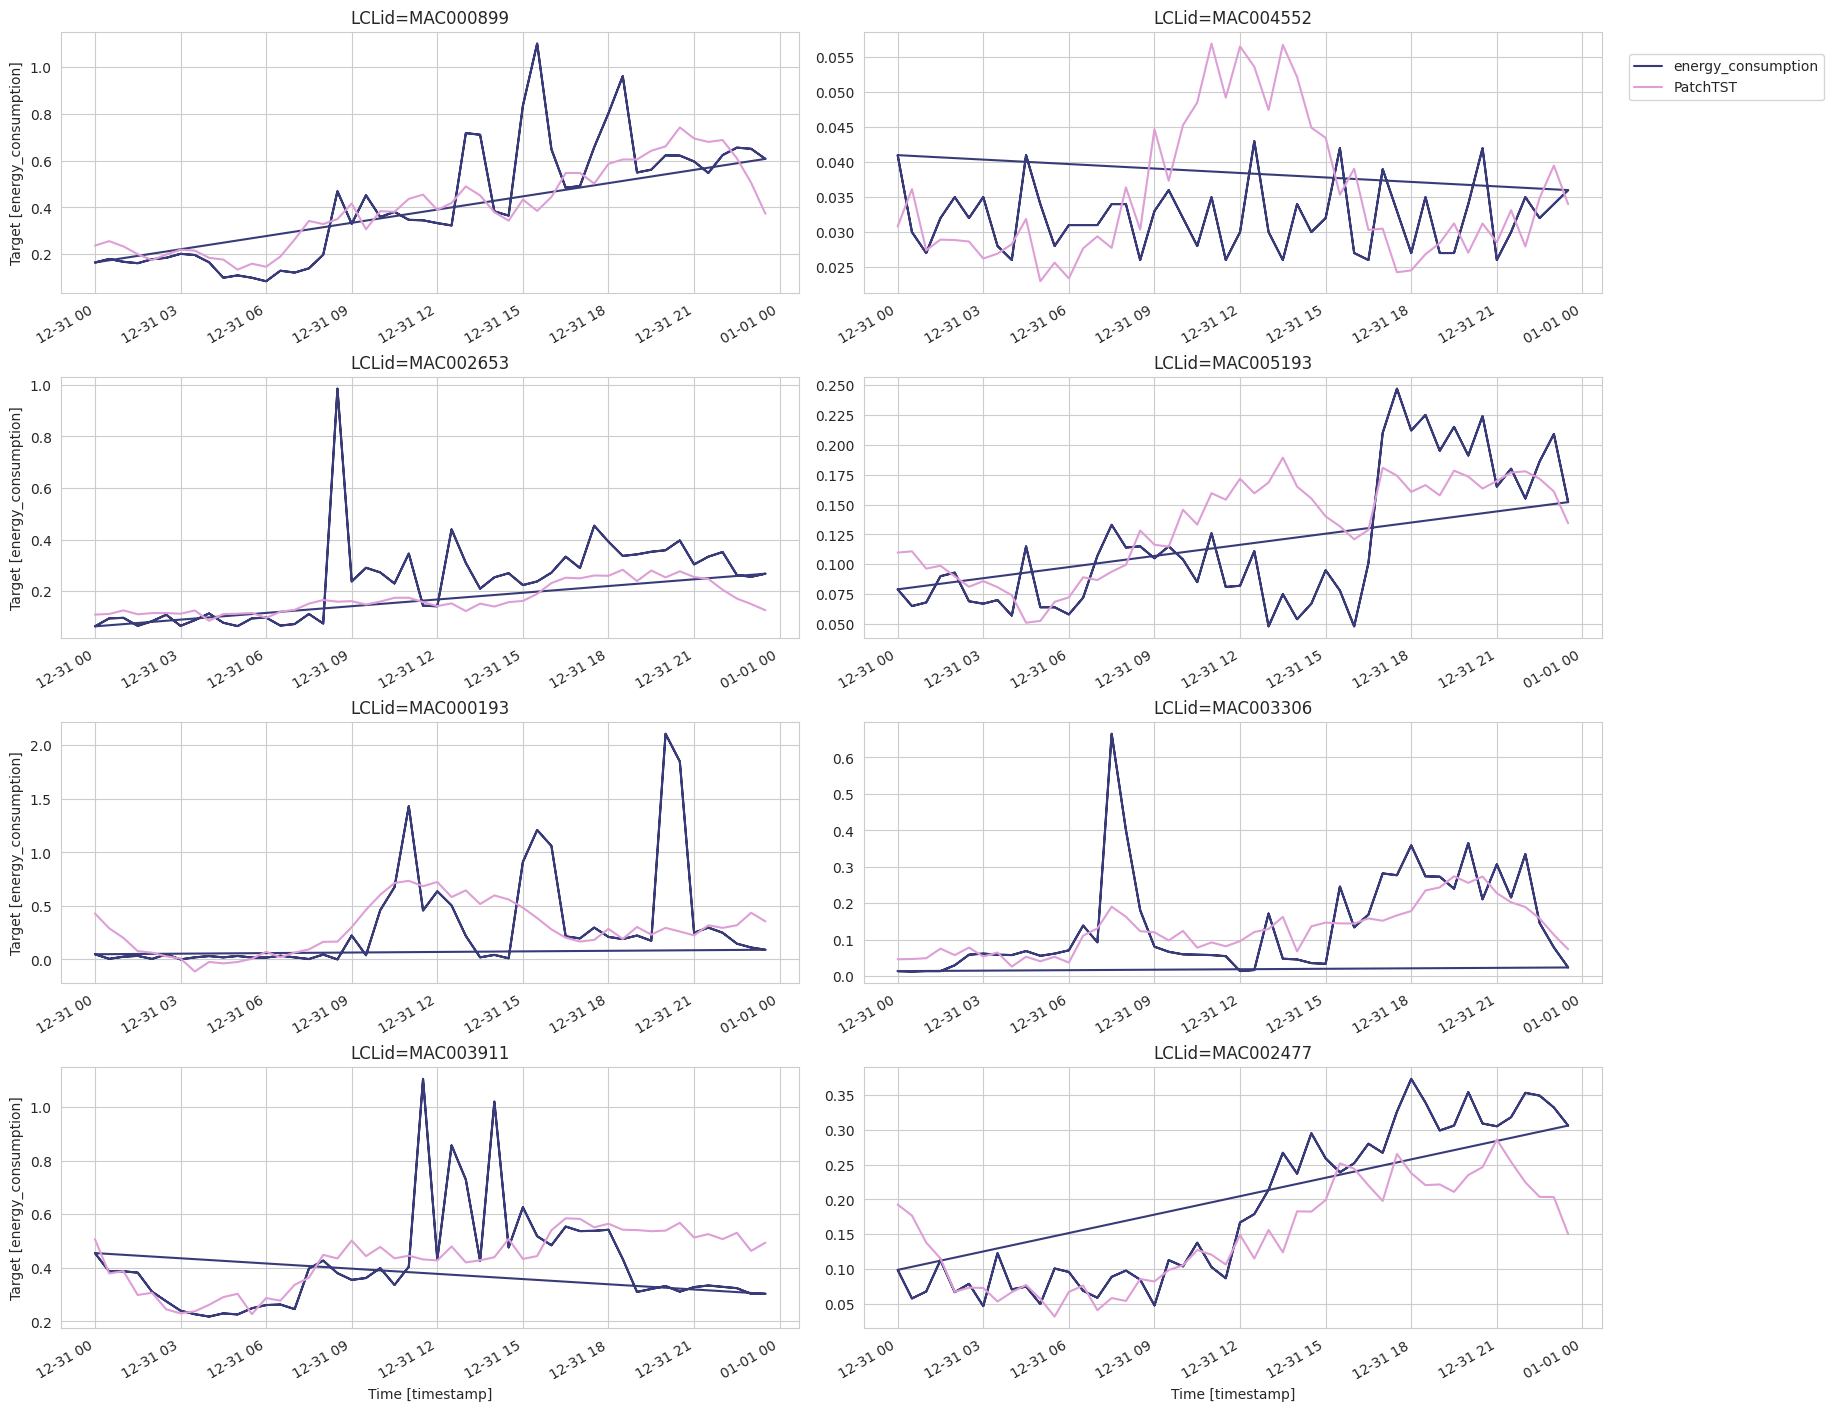

In [15]:
#visualize results
StatsForecast.plot(validation_df[['LCLid','timestamp','energy_consumption']], 
                   pred_df, engine='matplotlib', 
                   id_col='LCLid',
                   time_col= 'timestamp', 
                   target_col='energy_consumption',
                   models=['PatchTST'])

#### Evaluate PatchTST forecast

In [16]:
fcst_mase = partial(mase, seasonality=48)

# Get metrics for individual LCLid's
PatchTST_metrics = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption'
        )

# Get aggregated metrics for across all LCLid's by model
PatchTST_metrics_agg = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        agg_fn='mean'
        )

In [17]:
PatchTST_metrics_agg

metric  PatchTST
0   rmse  0.129651
1    mae  0.082924
2    mse  0.031019
3   mase  0.749979

## PatchTST Tuned
Since hyperparameters are key to performance in Neural Networks, NIXTLA has made this search each through the incorporation of Auto forecast.
Each NeuralForecast model has an AUTO class which allow you to easily tune your hyperparameters.

Auto Forecast can time, you can load the pre-trained hyperparameters or choose to retune on your own.
Set ```RETUNE = True``` if you wish to retune.


In [18]:
# Define the file path
config_file_path = 'notebooks/Chapter16/saved_params_config/PatchTST_best_config.json'
try:
    with open(config_file_path, 'r') as config_file:
        loaded_config = json.load(config_file)
        print(loaded_config)
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. 
    </div>
    """))
    

{'max_steps': 50, 'input_size': 48, 'learning_rate': 0.011975909666237397, 'scaler_type': 'standard', 'batch_size': 32, 'valid_batch_size': 16, 'hidden_size': 64, 'random_seed': 10}


In [32]:
PatchTST_config = {
    "max_steps": max_steps,  # This parameter can be adjusted if needed
    "input_size": tune.choice([h,h*7,h*7*2,h*7*3]), # Size of input window
    "learning_rate": tune.loguniform(1e-3,1e-2, 1e-1),  # Initial learning rate
    "scaler_type": tune.choice(["minmax", "standard"]),
    "batch_size": tune.choice([32, 64,128]),
    "valid_batch_size": tune.choice([32, 64,128]),
    #"early_stop_patience_steps": 3,
    "hidden_size": tune.choice([32, 64,128]),
    #"windows_batch_size": 128,
    "random_seed": tune.choice([10, 20,30]),
    #"n_head":tune.choice([64, 128])

}

if RETUNE == True:
    models = [AutoPatchTST(h=h, 
                     config = PatchTST_config,
                     search_alg = HyperOptSearch(),
                     backend = 'ray',
                     num_samples = 50,
                     cpus=10
                     )]

else:
    models = [AutoPatchTST(h=h, 
                    config = loaded_config,
                    search_alg = None,
                    backend = 'ray',
                    #cpus=1
                    )]


model_tuned = NeuralForecast(models=models, freq='30min')
model_tuned.fit(training_df[['LCLid','timestamp','energy_consumption']], id_col = 'LCLid',time_col = 'timestamp',target_col='energy_consumption',  val_size = 48)

(_train_tune pid=432174) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=432174) Seed set to 30
(_train_tune pid=432174) GPU available: False, used: False
(_train_tune pid=432174) TPU available: False, using: 0 TPU cores
(_train_tune pid=432174) IPU available: False, using: 0 IPUs
(_train_tune pid=432174) HPU available: False, using: 0 HPUs
(_train_tune pid=432174) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_45406547_1_batch_size=64,h=48,hidden_size=128,input_size=336,learning_rate=0.0055,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_18-50-27/lightning_logs
(_train_tune pid=432174) 
(_train_tune pid=432174)   | Name         | Type              | Params
(_train_tune pid=432174) ---------------------------

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=432378) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead. [repeated 2x across cluster]
(_train_tune pid=432378) Seed set to 10 [repeated 2x across cluster]
(_train_tune pid=432272) GPU available: False, used: False
(_train_tune pid=432272) TPU available: False, using: 0 TPU cores
(_train_tune pid=432272) IPU available: False, using: 0 IPUs
(_train_tune pid=432272) HPU available: False, using: 0 HPUs
(_train_tune pid=432272) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_62ee31a5_2_batch_size=64,h=48,hidden_size=128,input_size=336,learning_rate=0.0042,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_18-50-31/lightning_logs
(_train_tune pid=432272) 
(_train_tune pid=432272)   | Name         | Type              | P

Epoch 5:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=2.540, train_loss_epoch=2.540]


(_train_tune pid=432547) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=432547) Seed set to 20
(_train_tune pid=432547) --------------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=432547) GPU available: False, used: False
(_train_tune pid=432547) TPU available: False, using: 0 TPU cores
(_train_tune pid=432547) IPU available: False, using: 0 IPUs
(_train_tune pid=432547) HPU available: False, using: 0 HPUs


Epoch 8:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.796, train_loss_epoch=0.796]


(_train_tune pid=432692) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=432692) Seed set to 10
(_train_tune pid=432547) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_c5d972db_4_batch_size=32,h=48,hidden_size=32,input_size=336,learning_rate=0.0068,loss=ref_ph_de895953,max_steps=100,ra_2024-08-16_18-50-39/lightning_logs
(_train_tune pid=432547) 
(_train_tune pid=432547)   | Name         | Type              | Params
(_train_tune pid=432547) 0 | loss         | MAE               | 0     
(_train_tune pid=432547) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432547) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432547) 3 | model        | PatchTST_backbone | 129 K 
(_train_tune pi

Epoch 13:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.010, train_loss_epoch=1.010] 

(_train_tune pid=432856) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=432856) Seed set to 20
(_train_tune pid=432856) GPU available: False, used: False
(_train_tune pid=432856) TPU available: False, using: 0 TPU cores
(_train_tune pid=432856) IPU available: False, using: 0 IPUs
(_train_tune pid=432856) HPU available: False, using: 0 HPUs
(_train_tune pid=432856) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_8d1d1df3_6_batch_size=32,h=48,hidden_size=32,input_size=672,learning_rate=0.0098,loss=ref_ph_de895953,max_steps=100,ra_2024-08-16_18-50-48/lightning_logs
(_train_tune pid=432856) 
(_train_tune pid=432856)   | Name         | Type              | Params
(_train_tune pid=432856) ---------------------------

Epoch 21:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.803, train_loss_epoch=0.803] 

(_train_tune pid=433017) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=433017) Seed set to 30
(_train_tune pid=433017) GPU available: False, used: False
(_train_tune pid=433017) TPU available: False, using: 0 TPU cores
(_train_tune pid=433017) IPU available: False, using: 0 IPUs
(_train_tune pid=433017) HPU available: False, using: 0 HPUs
(_train_tune pid=433017) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_7754c5c8_7_batch_size=128,h=48,hidden_size=64,input_size=48,learning_rate=0.0037,loss=ref_ph_de895953,max_steps=100,ra_2024-08-16_18-50-55/lightning_logs
(_train_tune pid=433017) 
(_train_tune pid=433017)   | Name         | Type              | Params
(_train_tune pid=433017) ---------------------------

Epoch 20:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.118, train_loss_epoch=0.118] 

(_train_tune pid=433182) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=433182) Seed set to 30
(_train_tune pid=433182) GPU available: False, used: False
(_train_tune pid=433182) TPU available: False, using: 0 TPU cores
(_train_tune pid=433182) IPU available: False, using: 0 IPUs
(_train_tune pid=433182) HPU available: False, using: 0 HPUs


Epoch 19:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.106, train_loss_epoch=0.106] 

(_train_tune pid=433182) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_befa6c38_8_batch_size=128,h=48,hidden_size=128,input_size=48,learning_rate=0.0061,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_18-51-03/lightning_logs
(_train_tune pid=433182) 
(_train_tune pid=433182)   | Name         | Type              | Params
(_train_tune pid=433182) ---------------------------------------------------
(_train_tune pid=433182) 0 | loss         | MAE               | 0     
(_train_tune pid=433182) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=433182) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=433182) 3 | model        | PatchTST_backbone | 437 K 
(_train_tune pid=433182) ---------------------------------------------------
(_train_tune pid=433182) 437 K     Trainable params
(_train_tune pid=433182) 3         Non-trainable params
(_train_tune pid=433182) 437 K     Total params
(_train_tune pid=433182) 1.749     

Epoch 24:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.115, train_loss_epoch=0.115]


(_train_tune pid=433390) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=433390) Seed set to 20
(_train_tune pid=433390) GPU available: False, used: False
(_train_tune pid=433390) TPU available: False, using: 0 TPU cores
(_train_tune pid=433390) IPU available: False, using: 0 IPUs
(_train_tune pid=433390) HPU available: False, using: 0 HPUs


Epoch 15:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.000, train_loss_epoch=1.000]


(_train_tune pid=433390) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_7253459a_9_batch_size=32,h=48,hidden_size=128,input_size=48,learning_rate=0.0067,loss=ref_ph_de895953,max_steps=100,ra_2024-08-16_18-51-12/lightning_logs
(_train_tune pid=433390) 
(_train_tune pid=433390)   | Name         | Type              | Params
(_train_tune pid=433390) ---------------------------------------------------
(_train_tune pid=433390) 0 | loss         | MAE               | 0     
(_train_tune pid=433390) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=433390) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=433390) 3 | model        | PatchTST_backbone | 437 K 
(_train_tune pid=433390) ---------------------------------------------------
(_train_tune pid=433390) 437 K     Trainable params
(_train_tune pid=433390) 3         Non-trainable params
(_train_tune pid=433390) 437 K     Total params
(_train_tune pid=433390) 1.749     

Epoch 45:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.100, train_loss_epoch=0.100]


2024-08-16 18:51:52,791	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=433017) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=433017) Seed set to 10


(_train_tune pid=433017) 


(_train_tune pid=433017) GPU available: False, used: False
(_train_tune pid=433017) TPU available: False, using: 0 TPU cores
(_train_tune pid=433017) IPU available: False, using: 0 IPUs
(_train_tune pid=433017) HPU available: False, using: 0 HPUs
(_train_tune pid=433017) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_d412e031_10_batch_size=32,h=48,hidden_size=32,input_size=1008,learning_rate=0.0055,loss=ref_ph_de895953,max_steps=100,_2024-08-16_18-51-23/lightning_logs
(_train_tune pid=433017) 
(_train_tune pid=433017)   | Name         | Type              | Params
(_train_tune pid=433017) ---------------------------------------------------
(_train_tune pid=433017) 0 | loss         | MAE               | 0     
(_train_tune pid=433017) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=433017) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=433017) 3 | model        | PatchTST_backbone | 261 K 
(_train_tune pid=4330

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s, v_num=0, train_loss_step=1.050, train_loss_epoch=1.260]


(_train_tune pid=433182) `Trainer.fit` stopped: `max_steps=100` reached.
2024-08-16 18:52:40,665	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=433182) Seed set to 10


Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 0/1 [00:00<?, ?it/s]


(_train_tune pid=433182) GPU available: False, used: False
(_train_tune pid=433182) TPU available: False, using: 0 TPU cores
(_train_tune pid=433182) IPU available: False, using: 0 IPUs
(_train_tune pid=433182) HPU available: False, using: 0 HPUs
(_train_tune pid=433182) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_aa4ca637_11_batch_size=64,h=48,hidden_size=64,input_size=672,learning_rate=0.0035,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_18-51-52/lightning_logs
(_train_tune pid=433182) 
(_train_tune pid=433182)   | Name         | Type              | Params
(_train_tune pid=433182) ---------------------------------------------------
(_train_tune pid=433182) 0 | loss         | MAE               | 0     
(_train_tune pid=433182) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=433182) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=433182) 3 | model        | PatchTST_backbone | 414 K 
(_train_tune pid=4331

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s, v_num=0, train_loss_step=0.292, train_loss_epoch=0.220]


2024-08-16 18:52:56,804	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=433390) 
Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.94it/s, v_num=0, train_loss_step=0.292, train_loss_epoch=

(_train_tune pid=433390) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=433390) Seed set to 10
(_train_tune pid=433390) GPU available: False, used: False
(_train_tune pid=433390) TPU available: False, using: 0 TPU cores
(_train_tune pid=433390) IPU available: False, using: 0 IPUs
(_train_tune pid=433390) HPU available: False, using: 0 HPUs
(_train_tune pid=433390) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_59d8bb6f_12_batch_size=32,h=48,hidden_size=32,input_size=1008,learning_rate=0.0013,loss=ref_ph_de895953,max_steps=100,_2024-08-16_18-52-40/lightning_logs


Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 0/1 [00:00<?, ?it/s]


(_train_tune pid=433390) 
(_train_tune pid=433390)   | Name         | Type              | Params
(_train_tune pid=433390) ---------------------------------------------------
(_train_tune pid=433390) 0 | loss         | MAE               | 0     
(_train_tune pid=433390) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=433390) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=433390) 3 | model        | PatchTST_backbone | 261 K 
(_train_tune pid=433390) ---------------------------------------------------
(_train_tune pid=433390) 261 K     Trainable params
(_train_tune pid=433390) 3         Non-trainable params
(_train_tune pid=433390) 261 K     Total params
(_train_tune pid=433390) 1.045     Total estimated model params size (MB)


Epoch 99:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.107, train_loss_epoch=0.107]


2024-08-16 18:53:29,520	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.51it/s, v_num=0, train_loss_step=0.0823, train_loss_epoch=0.107]


(_train_tune pid=432547) `Trainer.fit` stopped: `max_steps=100` reached.


Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 0/1 [00:00<?, ?it/s]


(_train_tune pid=432547) Seed set to 30
(_train_tune pid=432547) GPU available: False, used: False
(_train_tune pid=432547) TPU available: False, using: 0 TPU cores
(_train_tune pid=432547) IPU available: False, using: 0 IPUs
(_train_tune pid=432547) HPU available: False, using: 0 HPUs
(_train_tune pid=432547) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_e994a59a_13_batch_size=128,h=48,hidden_size=128,input_size=1008,learning_rate=0.0029,loss=ref_ph_de895953,max_steps=10_2024-08-16_18-52-56/lightning_logs
(_train_tune pid=432547) 
(_train_tune pid=432547)   | Name         | Type              | Params
(_train_tune pid=432547) ---------------------------------------------------
(_train_tune pid=432547) 0 | loss         | MAE               | 0     
(_train_tune pid=432547) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432547) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432547) 3 | model        | PatchTST

Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]


2024-08-16 18:53:32,456	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432378) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=432378) 3 | model        | PatchTST_backbone | 169 K 
(_train_tune pid=432378) 169 K     Trainable params
(_train_tune pid=432378) 169 K     Total params


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.52it/s, v_num=0, train_loss_step=0.846, train_loss_epoch=0.655]


2024-08-16 18:53:54,077	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.56it/s]


(_train_tune pid=432692) Seed set to 30 [repeated 2x across cluster]
(_train_tune pid=432378) GPU available: False, used: False
(_train_tune pid=432378) TPU available: False, using: 0 TPU cores
(_train_tune pid=432378) IPU available: False, using: 0 IPUs
(_train_tune pid=432378) HPU available: False, using: 0 HPUs
(_train_tune pid=432378) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_81843efe_14_batch_size=64,h=48,hidden_size=64,input_size=48,learning_rate=0.0098,loss=ref_ph_de895953,max_steps=100,ra_2024-08-16_18-53-29/lightning_logs
(_train_tune pid=432378) 
(_train_tune pid=432378)   | Name         | Type              | Params
(_train_tune pid=432378) --------------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=432378) 0 | loss         | MAE               | 0     
(_train_tune pid=432378) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432378) 2 | scaler       | TemporalNorm      | 0

(_train_tune pid=432692) 
Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.55it/s, v_num=0, train_loss_step=0.849, train_loss_epoch

(_train_tune pid=432692) GPU available: False, used: False
(_train_tune pid=432692) TPU available: False, using: 0 TPU cores
(_train_tune pid=432692) IPU available: False, using: 0 IPUs
(_train_tune pid=432692) HPU available: False, using: 0 HPUs
(_train_tune pid=432692) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_d9bddc98_15_batch_size=32,h=48,hidden_size=64,input_size=336,learning_rate=0.0060,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_18-53-32/lightning_logs
(_train_tune pid=432692) 
(_train_tune pid=432692)   | Name         | Type              | Params
(_train_tune pid=432692) 0 | loss         | MAE               | 0     
(_train_tune pid=432692) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432692) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432692) 3 | model        | PatchTST_backbone | 282 K 
(_train_tune pid=432692) 282 K     Trainable params
(_train_tune pid=432692) 3         Non-trainab

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.40it/s, v_num=0, train_loss_step=1.030, train_loss_epoch=0.702]


2024-08-16 18:54:03,411	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432174) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=432174) 3 | model        | PatchTST_backbone | 1.2 M 
(_train_tune pid=432174) 1.2 M     Trainable params
(_train_tune pid=432174) 1.2 M     Total params
(_train_tune pid=432174) Seed set to 30
(_train_tune pid=432174) --------------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=432174) GPU available: False, used: False
(_train_tune pid=432174) TPU available: False, using: 0 TPU cores
(_train_tune pid=432174) IPU available: False, using: 0 IPUs
(_train_tune pid=432174) HPU available: False, using: 0 HPUs
(_train_tune pid=432174) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_4902f601_16_batch_size=64,h=48,hidden_size=

(_train_tune pid=432174) 
Epoch 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

2024-08-16 18:54:03,968	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432378) Seed set to 20
(_train_tune pid=432378) GPU available: False, used: False
(_train_tune pid=432378) TPU available: False, using: 0 TPU cores
(_train_tune pid=432378) IPU available: False, using: 0 IPUs
(_train_tune pid=432378) HPU available: False, using: 0 HPUs
(_train_tune pid=432378) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_4e2dd047_17_batch_size=128,h=48,hidden_size=32,input_size=672,learning_rate=0.0013,loss=ref_ph_de895953,max_steps=100,_2024-08-16_18-54-03/lightning_logs
(_train_tune pid=432378) 
(_train_tune pid=432378)   | Name         | Type              | Params
(_train_tune pid=432378) 0 | loss         | MAE               | 0     
(_train_tune pid=432378) 1 | padder_train | ConstantPad1d     | 0     


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  0.21it/s, v_num=0, train_loss_step=0.711, train_loss_epoch=0.776] 

2024-08-16 18:54:28,624	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432272) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]
(_train_tune pid=432272) --------------------------------------------------- [repeated 4x across cluster]
(_train_tune pid=432272) Seed set to 30
(_train_tune pid=432272) GPU available: False, used: False
(_train_tune pid=432272) TPU available: False, using: 0 TPU cores
(_train_tune pid=432272) IPU available: False, using: 0 IPUs
(_train_tune pid=432272) HPU available: False, using: 0 HPUs
(_train_tune pid=432272) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_fa14dbb0_18_batch_size=64,h=48,hidden_size=32,input_size=1008,learning_rate=0.0028,loss=ref_ph_de895953,max_steps=100,_2024-08-16_18-54-04/lightning_logs
(_train_tune pid=432272) 
(_tra

(_train_tune pid=432272) 
Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.39it/s, v_num=0, train_loss_step=0.0844, train_loss_epoch=

2024-08-16 18:57:39,383	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432692) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=432692) 
Epoch 99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.48it/s, v_num=0, train_loss_step=0.120,

(_train_tune pid=432692) Seed set to 30
(_train_tune pid=432692) GPU available: False, used: False
(_train_tune pid=432692) TPU available: False, using: 0 TPU cores
(_train_tune pid=432692) IPU available: False, using: 0 IPUs
(_train_tune pid=432692) HPU available: False, using: 0 HPUs
(_train_tune pid=432692) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_37c6ffec_19_batch_size=32,h=48,hidden_size=128,input_size=672,learning_rate=0.0028,loss=ref_ph_de895953,max_steps=100,_2024-08-16_18-54-28/lightning_logs
(_train_tune pid=432692) 
(_train_tune pid=432692)   | Name         | Type              | Params
(_train_tune pid=432692) ---------------------------------------------------
(_train_tune pid=432692) 0 | loss         | MAE               | 0     
(_train_tune pid=432692) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432692) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432692) 3 | model        | PatchTST

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-16 18:59:24,125	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432856) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=432856) 
Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  0.19it/s, v_num=0, train_loss_step=0.627, train_loss_epoch

(_train_tune pid=432856) Seed set to 10
(_train_tune pid=432856) GPU available: False, used: False
(_train_tune pid=432856) TPU available: False, using: 0 TPU cores
(_train_tune pid=432856) IPU available: False, using: 0 IPUs
(_train_tune pid=432856) HPU available: False, using: 0 HPUs
(_train_tune pid=432856) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_65cca235_20_batch_size=64,h=48,hidden_size=64,input_size=336,learning_rate=0.0090,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_18-57-39/lightning_logs
(_train_tune pid=432856) 
(_train_tune pid=432856)   | Name         | Type              | Params
(_train_tune pid=432856) ---------------------------------------------------
(_train_tune pid=432856) 0 | loss         | MAE               | 0     
(_train_tune pid=432856) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432856) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432856) 3 | model        | PatchTST

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  0.19it/s, v_num=0, train_loss_step=0.550, train_loss_epoch=0.543]


2024-08-16 19:02:30,307	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 89:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.835, train_loss_epoch=0.835] 

(_train_tune pid=432378) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=432378) Seed set to 10
(_train_tune pid=432378) GPU available: False, used: False
(_train_tune pid=432378) TPU available: False, using: 0 TPU cores
(_train_tune pid=432378) IPU available: False, using: 0 IPUs
(_train_tune pid=432378) HPU available: False, using: 0 HPUs
(_train_tune pid=432378) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_479abc05_21_batch_size=64,h=48,hidden_size=64,input_size=336,learning_rate=0.0018,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_18-59-24/lightning_logs
(_train_tune pid=432378) 
(_train_tune pid=432378)   | Name         | Type              | Params
(_train_tune pid=432378) --------------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=432378) 0 | loss         | MAE               | 0     
(_train_tune pid=432378) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=4323

(_train_tune pid=432378) 
Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

2024-08-16 19:02:50,265	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Validation: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 0/? [00:00<?, ?it/s]


(_train_tune pid=432856) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.51it/s, v_num=0, train_loss_step=0.935, train_loss_epoch=0.935, valid_loss=0.105]


(_train_tune pid=432856) Seed set to 10
(_train_tune pid=432856) GPU available: False, used: False
(_train_tune pid=432856) TPU available: False, using: 0 TPU cores
(_train_tune pid=432856) IPU available: False, using: 0 IPUs
(_train_tune pid=432856) HPU available: False, using: 0 HPUs
(_train_tune pid=432856) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_6c8a7c61_22_batch_size=32,h=48,hidden_size=32,input_size=336,learning_rate=0.0022,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_19-02-30/lightning_logs
(_train_tune pid=432856) 
(_train_tune pid=432856)   | Name         | Type              | Params
(_train_tune pid=432856) ---------------------------------------------------
(_train_tune pid=432856) 0 | loss         | MAE               | 0     
(_train_tune pid=432856) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432856) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432856) 3 | model        | PatchTST

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-16 19:05:40,350	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.59it/s, v_num=0, train_loss_step=0.842, train_loss_epoch=0.656]


(_train_tune pid=432856) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.57it/s, v_num=0, train_loss_step=0.842, train_loss_epoch=0.842, valid_loss=0.0857]


(_train_tune pid=432856) Seed set to 10
(_train_tune pid=432856) GPU available: False, used: False
(_train_tune pid=432856) TPU available: False, using: 0 TPU cores
(_train_tune pid=432856) IPU available: False, using: 0 IPUs
(_train_tune pid=432856) HPU available: False, using: 0 HPUs
(_train_tune pid=432856) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_53c8639b_23_batch_size=32,h=48,hidden_size=64,input_size=336,learning_rate=0.0017,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_19-02-50/lightning_logs
(_train_tune pid=432856) 
(_train_tune pid=432856)   | Name         | Type              | Params
(_train_tune pid=432856) ---------------------------------------------------
(_train_tune pid=432856) 0 | loss         | MAE               | 0     
(_train_tune pid=432856) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432856) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432856) 3 | model        | PatchTST

Epoch 7:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.855, train_loss_epoch=0.855]


2024-08-16 19:06:00,771	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432378) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.46it/s, v_num=0, train_loss_step=0.851, train_loss_epoch=0.661]


(_train_tune pid=432378) Seed set to 10
(_train_tune pid=432378) GPU available: False, used: False
(_train_tune pid=432378) TPU available: False, using: 0 TPU cores
(_train_tune pid=432378) IPU available: False, using: 0 IPUs
(_train_tune pid=432378) HPU available: False, using: 0 HPUs
(_train_tune pid=432378) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_daa5ee17_24_batch_size=32,h=48,hidden_size=32,input_size=336,learning_rate=0.0011,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_19-05-40/lightning_logs
(_train_tune pid=432378) 
(_train_tune pid=432378)   | Name         | Type              | Params
(_train_tune pid=432378) ---------------------------------------------------
(_train_tune pid=432378) 0 | loss         | MAE               | 0     
(_train_tune pid=432378) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432378) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432378) 3 | model        | PatchTST

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-16 19:06:18,377	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  0.12it/s, v_num=0, train_loss_step=0.598, train_loss_epoch=0.622]


(_train_tune pid=433182) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 9:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.802, train_loss_epoch=0.802] 

(_train_tune pid=433182) Seed set to 10


Epoch 70:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0721, train_loss_epoch=0.0721]


(_train_tune pid=433182) GPU available: False, used: False
(_train_tune pid=433182) TPU available: False, using: 0 TPU cores
(_train_tune pid=433182) IPU available: False, using: 0 IPUs
(_train_tune pid=433182) HPU available: False, using: 0 HPUs
(_train_tune pid=433182) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_3e4be908_25_batch_size=32,h=48,hidden_size=64,input_size=336,learning_rate=0.0021,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_19-06-00/lightning_logs
(_train_tune pid=433182) 
(_train_tune pid=433182)   | Name         | Type              | Params
(_train_tune pid=433182) ---------------------------------------------------
(_train_tune pid=433182) 0 | loss         | MAE               | 0     
(_train_tune pid=433182) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=433182) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=433182) 3 | model        | PatchTST_backbone | 282 K 
(_train_tune pid=4331

Epoch 97:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.894, train_loss_epoch=0.894] 

2024-08-16 19:08:54,577	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432378) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=432378) Seed set to 10


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=0, train_loss_step=0.846, train_loss_epoch=0.649]


(_train_tune pid=432378) GPU available: False, used: False
(_train_tune pid=432378) TPU available: False, using: 0 TPU cores
(_train_tune pid=432378) IPU available: False, using: 0 IPUs
(_train_tune pid=432378) HPU available: False, using: 0 HPUs
(_train_tune pid=432378) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_9d85325c_26_batch_size=32,h=48,hidden_size=64,input_size=336,learning_rate=0.0020,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_19-06-18/lightning_logs
(_train_tune pid=432378) 
(_train_tune pid=432378)   | Name         | Type              | Params
(_train_tune pid=432378) ---------------------------------------------------
(_train_tune pid=432378) 0 | loss         | MAE               | 0     
(_train_tune pid=432378) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432378) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432378) 3 | model        | PatchTST_backbone | 282 K 
(_train_tune pid=4323

Epoch 47:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.814, train_loss_epoch=0.814] 

2024-08-16 19:08:59,687	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432856) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.49it/s, v_num=0, train_loss_step=0.845, train_loss_epoch=0.654]


(_train_tune pid=432856) Seed set to 10
(_train_tune pid=432856) GPU available: False, used: False
(_train_tune pid=432856) TPU available: False, using: 0 TPU cores
(_train_tune pid=432856) IPU available: False, using: 0 IPUs
(_train_tune pid=432856) HPU available: False, using: 0 HPUs
(_train_tune pid=432856) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_ce3e9728_27_batch_size=32,h=48,hidden_size=32,input_size=336,learning_rate=0.0010,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_19-08-54/lightning_logs
(_train_tune pid=432856) 
(_train_tune pid=432856)   | Name         | Type              | Params
(_train_tune pid=432856) ---------------------------------------------------
(_train_tune pid=432856) 0 | loss         | MAE               | 0     
(_train_tune pid=432856) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432856) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432856) 3 | model        | PatchTST

Epoch 78:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.788, train_loss_epoch=0.788] 

2024-08-16 19:10:06,938	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432692) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  0.14it/s, v_num=0, train_loss_step=0.632, train_loss_epoch=0.596]


(_train_tune pid=432692) Seed set to 10
(_train_tune pid=432692) GPU available: False, used: False
(_train_tune pid=432692) TPU available: False, using: 0 TPU cores
(_train_tune pid=432692) IPU available: False, using: 0 IPUs
(_train_tune pid=432692) HPU available: False, using: 0 HPUs
(_train_tune pid=432692) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_117fc671_28_batch_size=32,h=48,hidden_size=32,input_size=336,learning_rate=0.0015,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_19-08-59/lightning_logs
(_train_tune pid=432692) 
(_train_tune pid=432692)   | Name         | Type              | Params
(_train_tune pid=432692) ---------------------------------------------------
(_train_tune pid=432692) 0 | loss         | MAE               | 0     
(_train_tune pid=432692) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432692) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432692) 3 | model        | PatchTST

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.61it/s, v_num=0, train_loss_step=0.846, train_loss_epoch=0.648]


2024-08-16 19:11:51,062	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432856) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=432856) Seed set to 30


(_train_tune pid=432856) 
Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.58it/s, v_num=0, train_loss_step=0.846, train_loss_epoch=

(_train_tune pid=432856) GPU available: False, used: False
(_train_tune pid=432856) TPU available: False, using: 0 TPU cores
(_train_tune pid=432856) IPU available: False, using: 0 IPUs
(_train_tune pid=432856) HPU available: False, using: 0 HPUs
(_train_tune pid=432856) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_c23ea40f_29_batch_size=32,h=48,hidden_size=128,input_size=672,learning_rate=0.0025,loss=ref_ph_de895953,max_steps=100,_2024-08-16_19-10-07/lightning_logs
(_train_tune pid=432856) 
(_train_tune pid=432856)   | Name         | Type              | Params
(_train_tune pid=432856) ---------------------------------------------------
(_train_tune pid=432856) 0 | loss         | MAE               | 0     
(_train_tune pid=432856) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432856) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432856) 3 | model        | PatchTST_backbone | 926 K 
(_train_tune pid=4328

2024-08-16 19:11:58,132	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}



Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.77it/s]

(_train_tune pid=432272) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=432272) Seed set to 30


(_train_tune pid=432272) 
Epoch 99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00,  0.10it/s, v_num=0, train_loss_step=0.0667, train_loss_epoch=0

(_train_tune pid=432272) GPU available: False, used: False
(_train_tune pid=432272) TPU available: False, using: 0 TPU cores
(_train_tune pid=432272) IPU available: False, using: 0 IPUs
(_train_tune pid=432272) HPU available: False, using: 0 HPUs
(_train_tune pid=432272) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_38bf43e1_30_batch_size=128,h=48,hidden_size=128,input_size=672,learning_rate=0.0016,loss=ref_ph_de895953,max_steps=100_2024-08-16_19-11-51/lightning_logs
(_train_tune pid=432272) 
(_train_tune pid=432272)   | Name         | Type              | Params
(_train_tune pid=432272) ---------------------------------------------------
(_train_tune pid=432272) 0 | loss         | MAE               | 0     
(_train_tune pid=432272) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432272) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432272) 3 | model        | PatchTST_backbone | 926 K 
(_train_tune pid=4322

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  0.27it/s, v_num=0, train_loss_step=0.843, train_loss_epoch=0.665]


2024-08-16 19:12:05,514	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=433182) 
Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  0.26it/s, v_num=0, train_loss_step=0.843, train_loss_epoch=

(_train_tune pid=433182) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=433182) Seed set to 30
(_train_tune pid=433182) GPU available: False, used: False
(_train_tune pid=433182) TPU available: False, using: 0 TPU cores
(_train_tune pid=433182) IPU available: False, using: 0 IPUs
(_train_tune pid=433182) HPU available: False, using: 0 HPUs
(_train_tune pid=433182) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_a9c20a20_31_batch_size=32,h=48,hidden_size=128,input_size=672,learning_rate=0.0044,loss=ref_ph_de895953,max_steps=100,_2024-08-16_19-11-58/lightning_logs
(_train_tune pid=433182) 
(_train_tune pid=433182)   | Name         | Type              | Params
(_train_tune pid=433182) ---------------------------------------------------
(_train_tune pid=433182) 0 | loss         | MAE               | 0     
(_train_tune pid=433182) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=433182) 2 | scaler       | Tempor

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.51it/s, v_num=0, train_loss_step=0.842, train_loss_epoch=0.666]


2024-08-16 19:12:17,708	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432378) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=432378) Seed set to 30


(_train_tune pid=432378) 
Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.50it/s, v_num=0, train_loss_step=0.842, train_loss_epoch=

(_train_tune pid=432378) GPU available: False, used: False
(_train_tune pid=432378) TPU available: False, using: 0 TPU cores
(_train_tune pid=432378) IPU available: False, using: 0 IPUs
(_train_tune pid=432378) HPU available: False, using: 0 HPUs
(_train_tune pid=432378) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_9d31cde2_32_batch_size=32,h=48,hidden_size=128,input_size=672,learning_rate=0.0012,loss=ref_ph_de895953,max_steps=100,_2024-08-16_19-12-05/lightning_logs
(_train_tune pid=432378) 
(_train_tune pid=432378)   | Name         | Type              | Params
(_train_tune pid=432378) ---------------------------------------------------
(_train_tune pid=432378) 0 | loss         | MAE               | 0     
(_train_tune pid=432378) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432378) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432378) 3 | model        | PatchTST_backbone | 926 K 
(_train_tune pid=4323

Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00,  0.09it/s, v_num=0, train_loss_step=0.0686, train_loss_epoch=0.0665]


2024-08-16 19:12:32,940	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=433017) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=433017) 
Epoch 99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00,  0.09it/s, v_num=0, train_loss_step=0.0686, train_loss_epoch=0

(_train_tune pid=433017) Seed set to 30
(_train_tune pid=433017) GPU available: False, used: False
(_train_tune pid=433017) TPU available: False, using: 0 TPU cores
(_train_tune pid=433017) IPU available: False, using: 0 IPUs
(_train_tune pid=433017) HPU available: False, using: 0 HPUs
(_train_tune pid=433017) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_d81630b8_33_batch_size=32,h=48,hidden_size=128,input_size=672,learning_rate=0.0079,loss=ref_ph_de895953,max_steps=100,_2024-08-16_19-12-17/lightning_logs
(_train_tune pid=433017) 
(_train_tune pid=433017)   | Name         | Type              | Params
(_train_tune pid=433017) ---------------------------------------------------
(_train_tune pid=433017) 0 | loss         | MAE               | 0     
(_train_tune pid=433017) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=433017) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=433017) 3 | model        | PatchTST

Epoch 97:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0674, train_loss_epoch=0.0674] 

2024-08-16 19:13:12,845	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432692) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.60it/s, v_num=0, train_loss_step=0.845, train_loss_epoch=0.653]


(_train_tune pid=432692) Seed set to 20
(_train_tune pid=432692) GPU available: False, used: False
(_train_tune pid=432692) TPU available: False, using: 0 TPU cores
(_train_tune pid=432692) IPU available: False, using: 0 IPUs
(_train_tune pid=432692) HPU available: False, using: 0 HPUs
(_train_tune pid=432692) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_6f4c6261_34_batch_size=32,h=48,hidden_size=64,input_size=672,learning_rate=0.0048,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_19-12-33/lightning_logs
(_train_tune pid=432692) 
(_train_tune pid=432692)   | Name         | Type              | Params
(_train_tune pid=432692) ---------------------------------------------------
(_train_tune pid=432692) 0 | loss         | MAE               | 0     
(_train_tune pid=432692) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432692) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432692) 3 | model        | PatchTST

Epoch 10:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.290, train_loss_epoch=1.290]


2024-08-16 19:13:48,440	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=433390) 
Epoch 99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00,  0.08it/s, v_num=0, train_loss_step=0.0637, train_loss_epoch=0

(_train_tune pid=433390) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=433390) Seed set to 30
(_train_tune pid=433390) GPU available: False, used: False
(_train_tune pid=433390) TPU available: False, using: 0 TPU cores
(_train_tune pid=433390) IPU available: False, using: 0 IPUs
(_train_tune pid=433390) HPU available: False, using: 0 HPUs
(_train_tune pid=433390) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_07421ceb_35_batch_size=128,h=48,hidden_size=128,input_size=48,learning_rate=0.0037,loss=ref_ph_de895953,max_steps=100,_2024-08-16_19-13-12/lightning_logs
(_train_tune pid=433390) 
(_train_tune pid=433390)   | Name         | Type              | Params
(_train_tune pid=433390) ---------------------------------------------------
(_train_tune pid=433390) 0 | loss         | MAE               | 0     
(_train_tune pid=433390) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=433390) 2 | scaler       | Tempor

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-16 19:14:29,352	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432174) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=432174) Seed set to 20


(_train_tune pid=432174) 
Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00,  0.08it/s, v_num=0, train_loss_step=0.689, train_loss_epoch=

(_train_tune pid=432174) GPU available: False, used: False
(_train_tune pid=432174) TPU available: False, using: 0 TPU cores
(_train_tune pid=432174) IPU available: False, using: 0 IPUs
(_train_tune pid=432174) HPU available: False, using: 0 HPUs
(_train_tune pid=432174) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_41a46a6c_36_batch_size=32,h=48,hidden_size=64,input_size=672,learning_rate=0.0025,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_19-13-48/lightning_logs
(_train_tune pid=432174) 
(_train_tune pid=432174)   | Name         | Type              | Params
(_train_tune pid=432174) ---------------------------------------------------
(_train_tune pid=432174) 0 | loss         | MAE               | 0     
(_train_tune pid=432174) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432174) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432174) 3 | model        | PatchTST_backbone | 414 K 
(_train_tune pid=4321

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s, v_num=0, train_loss_step=0.242, train_loss_epoch=0.272]

2024-08-16 19:15:07,129	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}



Validation: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 0/? [00:00<?, ?it/s]

(_train_tune pid=433390) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=433390) Seed set to 30


Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 0/1 [00:00<?, ?it/s]


(_train_tune pid=433390) GPU available: False, used: False
(_train_tune pid=433390) TPU available: False, using: 0 TPU cores
(_train_tune pid=433390) IPU available: False, using: 0 IPUs
(_train_tune pid=433390) HPU available: False, using: 0 HPUs
(_train_tune pid=433390) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_1745524a_37_batch_size=32,h=48,hidden_size=128,input_size=672,learning_rate=0.0034,loss=ref_ph_de895953,max_steps=100,_2024-08-16_19-14-29/lightning_logs
(_train_tune pid=433390) 
(_train_tune pid=433390)   | Name         | Type              | Params
(_train_tune pid=433390) ---------------------------------------------------
(_train_tune pid=433390) 0 | loss         | MAE               | 0     
(_train_tune pid=433390) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=433390) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=433390) 3 | model        | PatchTST_backbone | 926 K 
(_train_tune pid=4333

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00,  0.08it/s, v_num=0, train_loss_step=0.603, train_loss_epoch=0.583]


2024-08-16 19:17:10,301	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Validation DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.47it/s]


(_train_tune pid=432547) `Trainer.fit` stopped: `max_steps=100` reached.


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=432547) Seed set to 10
(_train_tune pid=432547) GPU available: False, used: False
(_train_tune pid=432547) TPU available: False, using: 0 TPU cores
(_train_tune pid=432547) IPU available: False, using: 0 IPUs
(_train_tune pid=432547) HPU available: False, using: 0 HPUs
(_train_tune pid=432547) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_14c53f61_38_batch_size=128,h=48,hidden_size=64,input_size=48,learning_rate=0.0030,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_19-15-07/lightning_logs
(_train_tune pid=432547) 
(_train_tune pid=432547)   | Name         | Type              | Params
(_train_tune pid=432547) ---------------------------------------------------
(_train_tune pid=432547) 0 | loss         | MAE               | 0     
(_train_tune pid=432547) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432547) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432547) 3 | model        | PatchTST

2024-08-16 19:17:42,925	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s, v_num=0, train_loss_step=0.259, train_loss_epoch=0.257]


(_train_tune pid=432547) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=432547) Seed set to 20


Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=432547) GPU available: False, used: False
(_train_tune pid=432547) TPU available: False, using: 0 TPU cores
(_train_tune pid=432547) IPU available: False, using: 0 IPUs
(_train_tune pid=432547) HPU available: False, using: 0 HPUs
(_train_tune pid=432547) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_7d2ffdeb_39_batch_size=32,h=48,hidden_size=128,input_size=672,learning_rate=0.0025,loss=ref_ph_de895953,max_steps=100,_2024-08-16_19-17-10/lightning_logs
(_train_tune pid=432547) 
(_train_tune pid=432547)   | Name         | Type              | Params
(_train_tune pid=432547) ---------------------------------------------------
(_train_tune pid=432547) 0 | loss         | MAE               | 0     
(_train_tune pid=432547) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432547) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432547) 3 | model        | PatchTST_backbone | 926 K 
(_train_tune pid=4325

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  0.17it/s, v_num=0, train_loss_step=0.599, train_loss_epoch=0.593]


2024-08-16 19:22:49,586	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432692) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=432692) 
Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  0.17it/s, v_num=0, train_loss_step=0.599, train_loss_epoch=

(_train_tune pid=432692) Seed set to 30
(_train_tune pid=432692) GPU available: False, used: False
(_train_tune pid=432692) TPU available: False, using: 0 TPU cores
(_train_tune pid=432692) IPU available: False, using: 0 IPUs
(_train_tune pid=432692) HPU available: False, using: 0 HPUs
(_train_tune pid=432692) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_6e6e7f42_40_batch_size=32,h=48,hidden_size=64,input_size=1008,learning_rate=0.0012,loss=ref_ph_de895953,max_steps=100,_2024-08-16_19-17-42/lightning_logs
(_train_tune pid=432692) 
(_train_tune pid=432692)   | Name         | Type              | Params
(_train_tune pid=432692) ---------------------------------------------------
(_train_tune pid=432692) 0 | loss         | MAE               | 0     
(_train_tune pid=432692) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432692) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432692) 3 | model        | PatchTST

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  0.16it/s, v_num=0, train_loss_step=0.652, train_loss_epoch=0.599]


2024-08-16 19:23:25,852	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432856) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=432856) 
Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  0.15it/s, v_num=0, train_loss_step=0.652, train_loss_epoch=

(_train_tune pid=432856) Seed set to 10
(_train_tune pid=432856) GPU available: False, used: False
(_train_tune pid=432856) TPU available: False, using: 0 TPU cores
(_train_tune pid=432856) IPU available: False, using: 0 IPUs
(_train_tune pid=432856) HPU available: False, using: 0 HPUs
(_train_tune pid=432856) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_91d8b8a6_41_batch_size=128,h=48,hidden_size=128,input_size=48,learning_rate=0.0014,loss=ref_ph_de895953,max_steps=100,_2024-08-16_19-22-49/lightning_logs
(_train_tune pid=432856) 
(_train_tune pid=432856)   | Name         | Type              | Params
(_train_tune pid=432856) ---------------------------------------------------
(_train_tune pid=432856) 0 | loss         | MAE               | 0     
(_train_tune pid=432856) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432856) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432856) 3 | model        | PatchTST

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  0.15it/s, v_num=0, train_loss_step=0.597, train_loss_epoch=0.587]


2024-08-16 19:23:47,493	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432378) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=432378) Seed set to 30


(_train_tune pid=432378) 
Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  0.15it/s, v_num=0, train_loss_step=0.597, train_loss_epoch=

(_train_tune pid=432378) GPU available: False, used: False
(_train_tune pid=432378) TPU available: False, using: 0 TPU cores
(_train_tune pid=432378) IPU available: False, using: 0 IPUs
(_train_tune pid=432378) HPU available: False, using: 0 HPUs
(_train_tune pid=432378) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_f8fd9e46_42_batch_size=32,h=48,hidden_size=128,input_size=672,learning_rate=0.0024,loss=ref_ph_de895953,max_steps=100,_2024-08-16_19-23-26/lightning_logs
(_train_tune pid=432378) 
(_train_tune pid=432378)   | Name         | Type              | Params
(_train_tune pid=432378) ---------------------------------------------------
(_train_tune pid=432378) 0 | loss         | MAE               | 0     
(_train_tune pid=432378) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432378) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432378) 3 | model        | PatchTST_backbone | 926 K 
(_train_tune pid=4323

Epoch 99:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=1.150, train_loss_epoch=1.150] 

(_train_tune pid=432856) `Trainer.fit` stopped: `max_steps=100` reached.2024-08-16 19:24:01,871	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}



Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.27it/s, v_num=0, train_loss_step=1.190, train_loss_epoch=1.150]


(_train_tune pid=432856) Seed set to 30
(_train_tune pid=432856) GPU available: False, used: False
(_train_tune pid=432856) TPU available: False, using: 0 TPU cores
(_train_tune pid=432856) IPU available: False, using: 0 IPUs
(_train_tune pid=432856) HPU available: False, using: 0 HPUs
(_train_tune pid=432856) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_63c25cca_43_batch_size=32,h=48,hidden_size=128,input_size=672,learning_rate=0.0050,loss=ref_ph_de895953,max_steps=100,_2024-08-16_19-23-47/lightning_logs
(_train_tune pid=432856) 
(_train_tune pid=432856)   | Name         | Type              | Params
(_train_tune pid=432856) ---------------------------------------------------
(_train_tune pid=432856) 0 | loss         | MAE               | 0     
(_train_tune pid=432856) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432856) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432856) 3 | model        | PatchTST

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=432174) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  0.19it/s, v_num=0, train_loss_step=0.555, train_loss_epoch=0.562]


2024-08-16 19:24:16,985	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432174) Seed set to 30
(_train_tune pid=432174) GPU available: False, used: False
(_train_tune pid=432174) TPU available: False, using: 0 TPU cores
(_train_tune pid=432174) IPU available: False, using: 0 IPUs
(_train_tune pid=432174) HPU available: False, using: 0 HPUs
(_train_tune pid=432174) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_df100f59_44_batch_size=64,h=48,hidden_size=128,input_size=672,learning_rate=0.0040,loss=ref_ph_de895953,max_steps=100,_2024-08-16_19-24-01/lightning_logs
(_train_tune pid=432174) 
(_train_tune pid=432174)   | Name         | Type              | Params
(_train_tune pid=432174) ---------------------------------------------------
(_train_tune pid=432174) 0 | loss         | MAE               | 0

Epoch 8:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.131, train_loss_epoch=0.131] 

2024-08-16 19:24:23,517	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432272) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=432272) Seed set to 30


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  0.13it/s, v_num=0, train_loss_step=0.599, train_loss_epoch=0.583]


(_train_tune pid=432272) GPU available: False, used: False
(_train_tune pid=432272) TPU available: False, using: 0 TPU cores
(_train_tune pid=432272) IPU available: False, using: 0 IPUs
(_train_tune pid=432272) HPU available: False, using: 0 HPUs
(_train_tune pid=432272) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_f58af5f5_45_batch_size=32,h=48,hidden_size=128,input_size=672,learning_rate=0.0019,loss=ref_ph_de895953,max_steps=100,_2024-08-16_19-24-17/lightning_logs
(_train_tune pid=432272) 
(_train_tune pid=432272)   | Name         | Type              | Params
(_train_tune pid=432272) ---------------------------------------------------
(_train_tune pid=432272) 0 | loss         | MAE               | 0     
(_train_tune pid=432272) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432272) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=432272) 3 | model        | PatchTST_backbone | 926 K 
(_train_tune pid=4322

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00,  0.10it/s, v_num=0, train_loss_step=0.694, train_loss_epoch=0.719]


2024-08-16 19:28:22,194	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=433182) 
Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00,  0.10it/s, v_num=0, train_loss_step=0.694, train_loss_epoch=

(_train_tune pid=433182) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=433182) Seed set to 30
(_train_tune pid=433182) GPU available: False, used: False
(_train_tune pid=433182) TPU available: False, using: 0 TPU cores
(_train_tune pid=433182) IPU available: False, using: 0 IPUs
(_train_tune pid=433182) HPU available: False, using: 0 HPUs
(_train_tune pid=433182) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_b14116c3_46_batch_size=32,h=48,hidden_size=128,input_size=672,learning_rate=0.0032,loss=ref_ph_de895953,max_steps=100,_2024-08-16_19-24-23/lightning_logs
(_train_tune pid=433182) 
(_train_tune pid=433182)   | Name         | Type              | Params
(_train_tune pid=433182) ---------------------------------------------------
(_train_tune pid=433182) 0 | loss         | MAE               | 0     
(_train_tune pid=433182) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=433182) 2 | scaler       | Tempor

2024-08-16 19:28:44,127	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=433017) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=433017) 
Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  0.10it/s, v_num=0, train_loss_step=1.010, train_loss_epoch

(_train_tune pid=433017) Seed set to 30
(_train_tune pid=433017) GPU available: False, used: False
(_train_tune pid=433017) TPU available: False, using: 0 TPU cores
(_train_tune pid=433017) IPU available: False, using: 0 IPUs
(_train_tune pid=433017) HPU available: False, using: 0 HPUs
(_train_tune pid=433017) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_f7912765_47_batch_size=128,h=48,hidden_size=128,input_size=672,learning_rate=0.0027,loss=ref_ph_de895953,max_steps=100_2024-08-16_19-28-22/lightning_logs
(_train_tune pid=433017) 
(_train_tune pid=433017)   | Name         | Type              | Params
(_train_tune pid=433017) ---------------------------------------------------
(_train_tune pid=433017) 0 | loss         | MAE               | 0     
(_train_tune pid=433017) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=433017) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=433017) 3 | model        | PatchTST

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  0.13it/s, v_num=0, train_loss_step=0.551, train_loss_epoch=0.565]


2024-08-16 19:30:34,853	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 58:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.816, train_loss_epoch=0.816] 

(_train_tune pid=432547) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=432547) Seed set to 30
(_train_tune pid=432547) GPU available: False, used: False
(_train_tune pid=432547) TPU available: False, using: 0 TPU cores
(_train_tune pid=432547) IPU available: False, using: 0 IPUs
(_train_tune pid=432547) HPU available: False, using: 0 HPUs
(_train_tune pid=432547) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_af8ada0a_48_batch_size=64,h=48,hidden_size=128,input_size=1008,learning_rate=0.0038,loss=ref_ph_de895953,max_steps=100_2024-08-16_19-28-44/lightning_logs
(_train_tune pid=432547) 
(_train_tune pid=432547)   | Name         | Type              | Params
(_train_tune pid=432547) ---------------------------------------------------
(_train_tune pid=432547) 0 | loss         | MAE               | 0     
(_train_tune pid=432547) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=432547) 2 | scaler       | Tempor

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-16 19:32:25,461	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=433390) 
Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00,  0.09it/s, v_num=0, train_loss_step=0.760, train_loss_epoch=

(_train_tune pid=433390) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=433390) Seed set to 30
(_train_tune pid=433390) GPU available: False, used: False
(_train_tune pid=433390) TPU available: False, using: 0 TPU cores
(_train_tune pid=433390) IPU available: False, using: 0 IPUs
(_train_tune pid=433390) HPU available: False, using: 0 HPUs
(_train_tune pid=433390) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_9bd54821_49_batch_size=32,h=48,hidden_size=128,input_size=672,learning_rate=0.0054,loss=ref_ph_de895953,max_steps=100,_2024-08-16_19-30-34/lightning_logs
(_train_tune pid=433390) 
(_train_tune pid=433390)   | Name         | Type              | Params
(_train_tune pid=433390) ---------------------------------------------------
(_train_tune pid=433390) 0 | loss         | MAE               | 0     
(_train_tune pid=433390) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=433390) 2 | scaler       | Tempor

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


2024-08-16 19:35:24,215	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Validation DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]


(_train_tune pid=432378) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=432378) Seed set to 20
(_train_tune pid=432378) GPU available: False, used: False
(_train_tune pid=432378) TPU available: False, using: 0 TPU cores
(_train_tune pid=432378) IPU available: False, using: 0 IPUs
(_train_tune pid=432378) HPU available: False, using: 0 HPUs
(_train_tune pid=432378) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_18-50-27/_train_tune_96b4f173_50_batch_size=64,h=48,hidden_size=128,input_size=48,learning_rate=0.0070,loss=ref_ph_de895953,max_steps=100,r_2024-08-16_19-32-25/lightning_logs
(_train_tune pid=432378) 
(_train_tune pid=432378)   | Name         | Type              | Params
(_train_tune pid=432378) --------------------------------------------------- [repeated 2x across cluster]
(_train_tune pid=432378) 0 | loss         | MAE               | 0     
(_train_tune pid=432378) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=4323

(_train_tune pid=432378) 
Epoch 2:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.316

2024-08-16 19:35:28,455	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  0.15it/s, v_num=0, train_loss_step=0.715, train_loss_epoch=0.704]


2024-08-16 19:35:46,950	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432174) `Trainer.fit` stopped: `max_steps=100` reached. [repeated 2x across cluster]


Epoch 45:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.696, train_loss_epoch=0.696] 

2024-08-16 19:35:54,424	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432378) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.89it/s, v_num=0, train_loss_step=0.290, train_loss_epoch=0.220]


2024-08-16 19:36:41,977	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


(_train_tune pid=432272) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=432272) 
Epoch 89:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.091

2024-08-16 19:39:16,597	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=432692) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  0.15it/s, v_num=0, train_loss_step=0.0684, train_loss_epoch=0.0647]


2024-08-16 19:39:40,678	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  0.30it/s, v_num=0, train_loss_step=0.656, train_loss_epoch=0.612]


(_train_tune pid=433182) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 78:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.786, train_loss_epoch=0.786] 

2024-08-16 19:39:47,726	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=433017) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.40it/s, v_num=0, train_loss_step=0.0934, train_loss_epoch=0.0736]


2024-08-16 19:40:30,255	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.51it/s, v_num=0, train_loss_step=0.906, train_loss_epoch=0.834]


(_train_tune pid=433390) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.637, train_loss_epoch=0.637]


2024-08-16 19:42:00,418	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.35it/s, v_num=0, train_loss_step=0.633, train_loss_epoch=0.637]


(_train_tune pid=432547) `Trainer.fit` stopped: `max_steps=100` reached.
Seed set to 30
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | loss         | MAE               | 0     
1 | padder_train | ConstantPad1d     | 0     
2 | scaler       | TemporalNorm      | 0     
3 | model        | PatchTST_backbone | 926 K 
---------------------------------------------------
926 K     Trainable params
3         Non-trainable params
926 K     Total params
3.706     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.


The results of the tuning can then be viewed by running the below.

In [33]:
PatchTST_best_config = model_tuned.models[0].results.get_best_result().config

# Remove specific keys using the pop method and then saving so we can extract parameters later
PatchTST_best_config.pop("loss", None)
PatchTST_best_config.pop("valid_loss", None)
PatchTST_best_config.pop("h", None)

# Save the filtered configuration to a JSON file
with open(config_file_path, 'w') as config_file:
    json.dump(PatchTST_best_config, config_file, indent=4)

print("Best configuration as string:")
print(PatchTST_best_config)

Best configuration as string:
{'max_steps': 100, 'input_size': 672, 'learning_rate': 0.0024997685901750506, 'scaler_type': 'standard', 'batch_size': 32, 'valid_batch_size': 128, 'hidden_size': 128, 'random_seed': 30}


In [34]:
results = model_tuned.models[0].results.get_dataframe()
results[['loss', 'train_loss', 'timestamp', 
       'training_iteration', 
        'config/max_steps', 'config/input_size',
       'config/learning_rate', 'config/h', 'config/loss',
       ]].head(2)

loss  train_loss   timestamp  training_iteration  config/max_steps  \
0  0.094594    1.025628  1723834443                   1               100   
1  0.090980    0.084386  1723834468                   1               100   

   config/input_size  config/learning_rate  config/h config/loss  
0                336              0.005479        48       MAE()  
1                336              0.004225        48       MAE()

In [35]:
pred_df_autoPatchTST =  model_tuned.predict(futr_df=validation_df[['LCLid','timestamp','energy_consumption']]).reset_index()
pred_df = pred_df_autoPatchTST.merge(pred_df[['LCLid','timestamp','energy_consumption','PatchTST']], on=['LCLid','timestamp'], how='left')
pred_df.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


LCLid           timestamp  AutoPatchTST  energy_consumption  PatchTST
0  MAC000126 2013-12-31 00:00:00      0.136973               0.093  0.135776
1  MAC000126 2013-12-31 00:30:00      0.087417               0.109  0.126084
2  MAC000126 2013-12-31 01:00:00      0.054567               0.082  0.084390
3  MAC000126 2013-12-31 01:30:00      0.092420               0.067  0.062649
4  MAC000126 2013-12-31 02:00:00      0.063085               0.043  0.038152

In [36]:
fcst_mase = partial(mase, seasonality=48)

autoPatchTST_metrics = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption'
        )

autoPatchTST_metrics_agg = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        agg_fn='mean'
        )

In [37]:
autoPatchTST_metrics_agg

metric  AutoPatchTST  PatchTST
0   rmse      0.135437  0.129651
1    mae      0.086988  0.082924
2    mse      0.032031  0.031019
3   mase      0.764997  0.749979

## TEST SET Predictions

In [38]:
h_test = len(test_df.timestamp.unique()) # horizon of the test set

if RETUNE == True:
    config = PatchTST_best_config
else:
    config = loaded_config

models_test = [AutoPatchTST(h=h_test, 
                    config = config,
                    search_alg = None,
                    backend = 'ray')]

models_test = NeuralForecast(models=models_test, freq='30min')
models_test.fit(train_df[['LCLid','timestamp','energy_consumption']], id_col = 'LCLid',time_col = 'timestamp',target_col='energy_consumption')

(_train_tune pid=446919) /anaconda/envs/demand_planning/lib/python3.10/site-packages/ray/tune/integration/pytorch_lightning.py:194: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=446919) Seed set to 30
(_train_tune pid=446919) GPU available: False, used: False
(_train_tune pid=446919) TPU available: False, using: 0 TPU cores
(_train_tune pid=446919) IPU available: False, using: 0 IPUs
(_train_tune pid=446919) HPU available: False, using: 0 HPUs
(_train_tune pid=446919) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_19-43-59/_train_tune_e1a3f_00000_0_2024-08-16_19-43-59/lightning_logs
(_train_tune pid=446919) 
(_train_tune pid=446919)   | Name         | Type              | Params
(_train_tune pid=446919) ---------------------------------------------------
(_train_tune pid=446919) 0 | loss         | MAE               | 0     
(_train_t

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=0, train_loss_step=0.747, train_loss_epoch=0.842]


(_train_tune pid=446919) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=446919) Seed set to 30


(_train_tune pid=446919) 
Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=0, train_loss_step=0.747, train_loss_epoch

(_train_tune pid=446919) GPU available: False, used: False
(_train_tune pid=446919) TPU available: False, using: 0 TPU cores
(_train_tune pid=446919) IPU available: False, using: 0 IPUs
(_train_tune pid=446919) HPU available: False, using: 0 HPUs
(_train_tune pid=446919) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_19-43-59/_train_tune_e1a3f_00001_1_2024-08-16_19-43-59/lightning_logs
(_train_tune pid=446919) 
(_train_tune pid=446919)   | Name         | Type              | Params
(_train_tune pid=446919) ---------------------------------------------------
(_train_tune pid=446919) 0 | loss         | MAE               | 0     
(_train_tune pid=446919) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=446919) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=446919) 3 | model        | PatchTST_backbone | 16.4 M
(_train_tune pid=446919) ---------------------------------------------------
(_train_tune pid=446919) 16.4 M    Trainable para

Epoch 99:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.842, train_loss_epoch=0.842]


(_train_tune pid=446919) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=0, train_loss_step=0.747, train_loss_epoch=0.842]


(_train_tune pid=446919) Seed set to 30
(_train_tune pid=446919) GPU available: False, used: False
(_train_tune pid=446919) TPU available: False, using: 0 TPU cores
(_train_tune pid=446919) IPU available: False, using: 0 IPUs
(_train_tune pid=446919) HPU available: False, using: 0 HPUs
(_train_tune pid=446919) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_19-43-59/_train_tune_e1a3f_00002_2_2024-08-16_19-43-59/lightning_logs
(_train_tune pid=446919) 
(_train_tune pid=446919)   | Name         | Type              | Params
(_train_tune pid=446919) ---------------------------------------------------
(_train_tune pid=446919) 0 | loss         | MAE               | 0     
(_train_tune pid=446919) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=446919) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=446919) 3 | model        | PatchTST_backbone | 16.4 M
(_train_tune pid=446919) ---------------------------------------------------
(_train_t

Epoch 99:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.842, train_loss_epoch=0.842]


(_train_tune pid=446919) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=446919) Seed set to 30


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.66it/s, v_num=0, train_loss_step=0.747, train_loss_epoch=0.842]


(_train_tune pid=446919) GPU available: False, used: False
(_train_tune pid=446919) TPU available: False, using: 0 TPU cores
(_train_tune pid=446919) IPU available: False, using: 0 IPUs
(_train_tune pid=446919) HPU available: False, using: 0 HPUs
(_train_tune pid=446919) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_19-43-59/_train_tune_e1a3f_00003_3_2024-08-16_19-43-59/lightning_logs
(_train_tune pid=446919) 
(_train_tune pid=446919)   | Name         | Type              | Params
(_train_tune pid=446919) ---------------------------------------------------
(_train_tune pid=446919) 0 | loss         | MAE               | 0     
(_train_tune pid=446919) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=446919) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=446919) 3 | model        | PatchTST_backbone | 16.4 M
(_train_tune pid=446919) ---------------------------------------------------
(_train_tune pid=446919) 16.4 M    Trainable para

Epoch 99:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.842, train_loss_epoch=0.842]


(_train_tune pid=446919) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=446919) Seed set to 30


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=0, train_loss_step=0.747, train_loss_epoch=0.842]


(_train_tune pid=446919) GPU available: False, used: False
(_train_tune pid=446919) TPU available: False, using: 0 TPU cores
(_train_tune pid=446919) IPU available: False, using: 0 IPUs
(_train_tune pid=446919) HPU available: False, using: 0 HPUs
(_train_tune pid=446919) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_19-43-59/_train_tune_e1a3f_00004_4_2024-08-16_19-43-59/lightning_logs
(_train_tune pid=446919) 
(_train_tune pid=446919)   | Name         | Type              | Params
(_train_tune pid=446919) ---------------------------------------------------
(_train_tune pid=446919) 0 | loss         | MAE               | 0     
(_train_tune pid=446919) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=446919) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=446919) 3 | model        | PatchTST_backbone | 16.4 M
(_train_tune pid=446919) ---------------------------------------------------
(_train_tune pid=446919) 16.4 M    Trainable para

Sanity Checking: |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 0/? [00:00<?, ?it/s]


(_train_tune pid=446919) `Trainer.fit` stopped: `max_steps=100` reached.
(_train_tune pid=446919) Seed set to 30


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.63it/s, v_num=0, train_loss_step=0.747, train_loss_epoch=0.842]


(_train_tune pid=446919) GPU available: False, used: False
(_train_tune pid=446919) TPU available: False, using: 0 TPU cores
(_train_tune pid=446919) IPU available: False, using: 0 IPUs
(_train_tune pid=446919) HPU available: False, using: 0 HPUs
(_train_tune pid=446919) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_19-43-59/_train_tune_e1a3f_00005_5_2024-08-16_19-43-59/lightning_logs
(_train_tune pid=446919) 
(_train_tune pid=446919)   | Name         | Type              | Params
(_train_tune pid=446919) ---------------------------------------------------
(_train_tune pid=446919) 0 | loss         | MAE               | 0     
(_train_tune pid=446919) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=446919) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=446919) 3 | model        | PatchTST_backbone | 16.4 M
(_train_tune pid=446919) ---------------------------------------------------
(_train_tune pid=446919) 16.4 M    Trainable para

Sanity Checking DataLoader 0:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 0/1 [00:00<?, ?it/s]


(_train_tune pid=446919) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=0, train_loss_step=0.747, train_loss_epoch=0.842]


(_train_tune pid=446919) Seed set to 30
(_train_tune pid=446919) GPU available: False, used: False
(_train_tune pid=446919) TPU available: False, using: 0 TPU cores
(_train_tune pid=446919) IPU available: False, using: 0 IPUs
(_train_tune pid=446919) HPU available: False, using: 0 HPUs
(_train_tune pid=446919) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_19-43-59/_train_tune_e1a3f_00006_6_2024-08-16_19-43-59/lightning_logs
(_train_tune pid=446919) 
(_train_tune pid=446919)   | Name         | Type              | Params
(_train_tune pid=446919) ---------------------------------------------------
(_train_tune pid=446919) 0 | loss         | MAE               | 0     
(_train_tune pid=446919) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=446919) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=446919) 3 | model        | PatchTST_backbone | 16.4 M
(_train_tune pid=446919) ---------------------------------------------------
(_train_t

Epoch 99:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.842, train_loss_epoch=0.842]


(_train_tune pid=446919) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.64it/s, v_num=0, train_loss_step=0.747, train_loss_epoch=0.842]


(_train_tune pid=446919) Seed set to 30
(_train_tune pid=446919) GPU available: False, used: False
(_train_tune pid=446919) TPU available: False, using: 0 TPU cores
(_train_tune pid=446919) IPU available: False, using: 0 IPUs
(_train_tune pid=446919) HPU available: False, using: 0 HPUs
(_train_tune pid=446919) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_19-43-59/_train_tune_e1a3f_00007_7_2024-08-16_19-43-59/lightning_logs
(_train_tune pid=446919) 
(_train_tune pid=446919)   | Name         | Type              | Params
(_train_tune pid=446919) ---------------------------------------------------
(_train_tune pid=446919) 0 | loss         | MAE               | 0     
(_train_tune pid=446919) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=446919) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=446919) 3 | model        | PatchTST_backbone | 16.4 M
(_train_tune pid=446919) ---------------------------------------------------
(_train_t

Epoch 99:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.842, train_loss_epoch=0.842]


(_train_tune pid=446919) `Trainer.fit` stopped: `max_steps=100` reached.


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=0, train_loss_step=0.747, train_loss_epoch=0.842]


(_train_tune pid=446919) Seed set to 30
(_train_tune pid=446919) GPU available: False, used: False
(_train_tune pid=446919) TPU available: False, using: 0 TPU cores
(_train_tune pid=446919) IPU available: False, using: 0 IPUs
(_train_tune pid=446919) HPU available: False, using: 0 HPUs
(_train_tune pid=446919) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_19-43-59/_train_tune_e1a3f_00008_8_2024-08-16_19-43-59/lightning_logs
(_train_tune pid=446919) 
(_train_tune pid=446919)   | Name         | Type              | Params
(_train_tune pid=446919) ---------------------------------------------------
(_train_tune pid=446919) 0 | loss         | MAE               | 0     
(_train_tune pid=446919) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=446919) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=446919) 3 | model        | PatchTST_backbone | 16.4 M
(_train_tune pid=446919) ---------------------------------------------------
(_train_t

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.66it/s, v_num=0, train_loss_step=0.747, train_loss_epoch=0.842]


(_train_tune pid=446919) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=446919) 
Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.65it/s, v_num=0, train_loss_step=0.747, train_loss_epoch

(_train_tune pid=446919) Seed set to 30
(_train_tune pid=446919) GPU available: False, used: False
(_train_tune pid=446919) TPU available: False, using: 0 TPU cores
(_train_tune pid=446919) IPU available: False, using: 0 IPUs
(_train_tune pid=446919) HPU available: False, using: 0 HPUs
(_train_tune pid=446919) Missing logger folder: /home/azureuser/ray_results/_train_tune_2024-08-16_19-43-59/_train_tune_e1a3f_00009_9_2024-08-16_19-43-59/lightning_logs
(_train_tune pid=446919) 
(_train_tune pid=446919)   | Name         | Type              | Params
(_train_tune pid=446919) ---------------------------------------------------
(_train_tune pid=446919) 0 | loss         | MAE               | 0     
(_train_tune pid=446919) 1 | padder_train | ConstantPad1d     | 0     
(_train_tune pid=446919) 2 | scaler       | TemporalNorm      | 0     
(_train_tune pid=446919) 3 | model        | PatchTST_backbone | 16.4 M
(_train_tune pid=446919) ---------------------------------------------------
(_train_t

Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.67it/s, v_num=0, train_loss_step=0.747, train_loss_epoch=0.842]


Seed set to 30
(_train_tune pid=446919) `Trainer.fit` stopped: `max_steps=100` reached.


(_train_tune pid=446919) 
Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  0.66it/s, v_num=0, train_loss_step=0.747, train_loss_epoch

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | loss         | MAE               | 0     
1 | padder_train | ConstantPad1d     | 0     
2 | scaler       | TemporalNorm      | 0     
3 | model        | PatchTST_backbone | 16.4 M
---------------------------------------------------
16.4 M    Trainable params
3         Non-trainable params
16.4 M    Total params
65.643    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.


In [39]:
pred_df_test =  models_test.predict(futr_df=test_df[['LCLid','timestamp','energy_consumption']]).reset_index()
pred_df_test = pred_df_test.merge(test_df[['LCLid','timestamp','energy_consumption']], on=['LCLid','timestamp'], how='left')
pred_df_test.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/anaconda/envs/demand_planning/lib/python3.10/site-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


LCLid           timestamp  AutoPatchTST  energy_consumption
0  MAC000126 2014-01-01 00:00:00      0.125554               0.193
1  MAC000126 2014-01-01 00:30:00      0.118989               0.119
2  MAC000126 2014-01-01 01:00:00      0.103685               0.130
3  MAC000126 2014-01-01 01:30:00      0.094636               0.086
4  MAC000126 2014-01-01 02:00:00      0.048128               0.067

In [40]:
fcst_mase = partial(mase, seasonality=48)

# Get metrics for individual LCLid's
PatchTST_metrics_test = evaluate(pred_df_test, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption'
        )

# Get aggregated metrics for across all LCLid's by model
PatchTST_metrics_agg_test = evaluate(pred_df_test, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        agg_fn='mean'
        )

In [41]:
PatchTST_metrics_agg_test

metric  AutoPatchTST
0   rmse      0.171245
1    mae      0.101968
2    mse      0.036148
3   mase      0.881343

In [42]:
PatchTST_metrics_test.head()

LCLid metric  AutoPatchTST
0  MAC000126   rmse      0.163027
1  MAC000193   rmse      0.351547
2  MAC000899   rmse      0.249573
3  MAC002477   rmse      0.146022
4  MAC002653   rmse      0.127922

In [43]:
PatchTST_metrics_agg_test.to_pickle(output/'PatchTST_metrics_agg_test.pkl')
PatchTST_metrics_test.to_pickle(output/'PatchTST_metrics_test.pkl')

Bad pipe message: %s [b'h\x03\xb7\xd9k\xae\xa043\xec\x15Jl@\xd8<\xd0\x96 \x81\xe7g\xe7\xe04ZMq%?\xa4QD\xc4`\x1e\xe9Q\xa3$\xef\xfa.b\xa0\x95\x07\xb7\xe3\xec\x8f\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06']
Bad pipe message: %s [b'\x05\x01\x06', b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 \xee\x04\xfaH+\x83\xc1C\xf4/\xdau_\xe9\xb8H\xd5;\xea.2\x95']
Bad pipe message: %s [b'\xb9\xb2g\xd7', b"2z:\xa9\x9f\x9f\xae\x0cV\xc5\x1eZ\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x